<a href="https://colab.research.google.com/github/chengzhuo1992/hello-world/blob/master/%E6%B5%8B%E9%87%8F%E6%95%B0%E6%8D%AE%E5%88%86%E6%9E%90%E4%B8%8E%E5%BB%BA%E6%A8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

测量分析数据与建模 \\
成卓 18214899 \\
中山大学 \\
物理与天文学院

课题：1973-2016年二氧化碳排放量的时间序列分析 \\
数据来源：U.S. Energy Infomation Administration（http://www.eia.gov/electricity/data.cfm#elecenv）

一、导入数据并将其转换为时间序列

In [0]:
!pip install PyDrive # install

In [0]:
#s授权google drive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#导入csv文件
from google.colab import files
files.upload()
#files.download('.csv')

Saving total_CO2.csv to total_CO2 (1).csv


{'total_CO2.csv': b'\xef\xbb\xbfYYYYMM,Value,Descirption,unit,,,\r\n197301,111.621,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,,,\r\n197302,99.185,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,,,\r\n197303,99.112,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,,,\r\n197304,93.183,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,,,\r\n197305,98.012,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,,,\r\n197306,109.66,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,,,\r\n197307,120.935,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,,,\r\n197308,125.189,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide,,,\r\n197309,111.452,Total Energy Electric Power Sector CO2 Emissions,Million M

In [0]:
#导入需要用到的库
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [0]:
import warnings
import itertools
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [0]:
#转换数据为index
dateparse = lambda x: pd.to_datetime(x, format='%Y%m', errors = 'coerce')
df = pd.read_csv('total_CO2.csv', parse_dates=['YYYYMM'], index_col='YYYYMM', date_parser=dateparse) 
df=df.drop(['Unnamed: 4','Unnamed: 5','Unnamed: 6'],axis=1)#删除空白列
df.head()

,Value,Descirption,unit
YYYYMM,,,
1973-01-01,111.621,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-02-01,99.185,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-03-01,99.112,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-04-01,93.183,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-05-01,98.012,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide


In [0]:
ts = df[pd.Series(pd.to_datetime(df.index, errors='coerce')).notnull().values]
ts.head()

,Value,Descirption,unit
YYYYMM,,,
1973-01-01,111.621,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-02-01,99.185,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-03-01,99.112,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-04-01,93.183,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-05-01,98.012,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide


In [0]:
ts.dtypes

Value          float64
Descirption     object
unit            object
dtype: object

In [0]:
ts['Value'] = pd.to_numeric(ts['Value'] , errors='coerce')
ts.head()

,Value,Descirption,unit
YYYYMM,,,
1973-01-01,111.621,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-02-01,99.185,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-03-01,99.112,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-04-01,93.183,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide
1973-05-01,98.012,Total Energy Electric Power Sector CO2 Emissions,Million Metric Tons of Carbon Dioxide


In [0]:
ts.dtypes

Value          float64
Descirption     object
unit            object
dtype: object

In [0]:
ts.dropna(inplace = True)
ts.index

DatetimeIndex(['1973-01-01', '1973-02-01', '1973-03-01', '1973-04-01',
               '1973-05-01', '1973-06-01', '1973-07-01', '1973-08-01',
               '1973-09-01', '1973-10-01',
               ...
               '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01',
               '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01'],
              dtype='datetime64[ns]', name='YYYYMM', length=523, freq=None)

In [0]:
ts_value = ts['Value']

二 、数据可视化

Text(0, 0.5, 'Carbon Emissions in MMT')

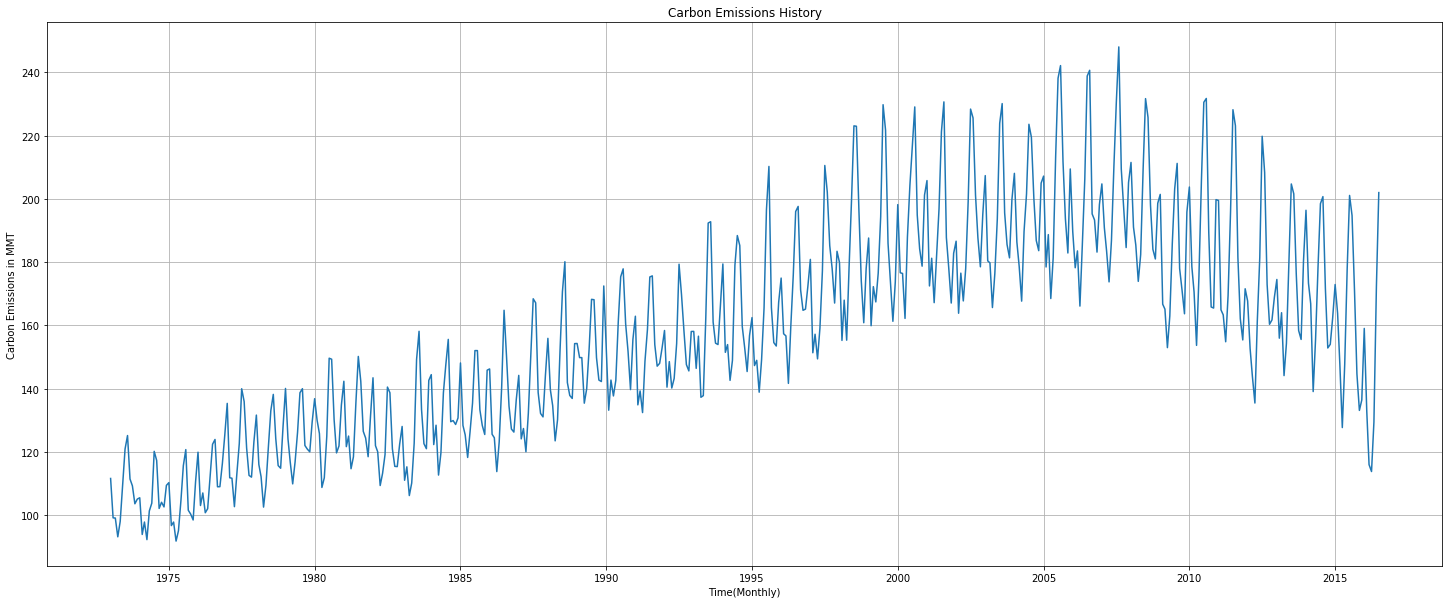

In [0]:
#对原始数据作图
plt.figure(figsize=(25,10)) #pic scale
plt.grid(True,'both')
plt.title('Carbon Emissions History')
plt.plot(ts_value)
plt.xlabel('Time(Monthly)')
plt.ylabel('Carbon Emissions in MMT')

三、检查数据稳定性、正态性

In [0]:
#检查数据结构
ts_value.head()

YYYYMM
1973-01-01    111.621
1973-02-01     99.185
1973-03-01     99.112
1973-04-01     93.183
1973-05-01     98.012
Name: Value, dtype: float64

ARMA模型处理的是平稳时间序列，首先我们需要从时间序列图像中判断总趋势和季节性趋势，采用差分剔除/拟合提取/指数平滑/异方差模型等方法去除趋势项 \\
平稳性检验：时间序列图/逆序检验/自相关图检验/单位根检验（Dickey-Fuller Test）/ADF检验法 \\
正态性检验：直方图/丰度/偏度/Jarque-Bera检验法/Kolmogorov-Smirnov检验法/正态分布概率图形法

In [0]:
#采用Dickey-Fuller方法检验平稳性
#绘制滑动平均值和滑动方差，查看均值和方差是否随时间变化
def TestStationaryPlot(ts_value):
    rol_mean = ts_value.rolling(window = 12, center = False).mean()
    rol_std = ts_value.rolling(window = 12, center = False).std()
    
    plt.figure(figsize=(25,10))
    plt.grid(True,'both')
    plt.plot(ts_value, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='green', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Total Emissions', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Mean & Standard Deviation', fontsize = 25)
    plt.show(block= True)

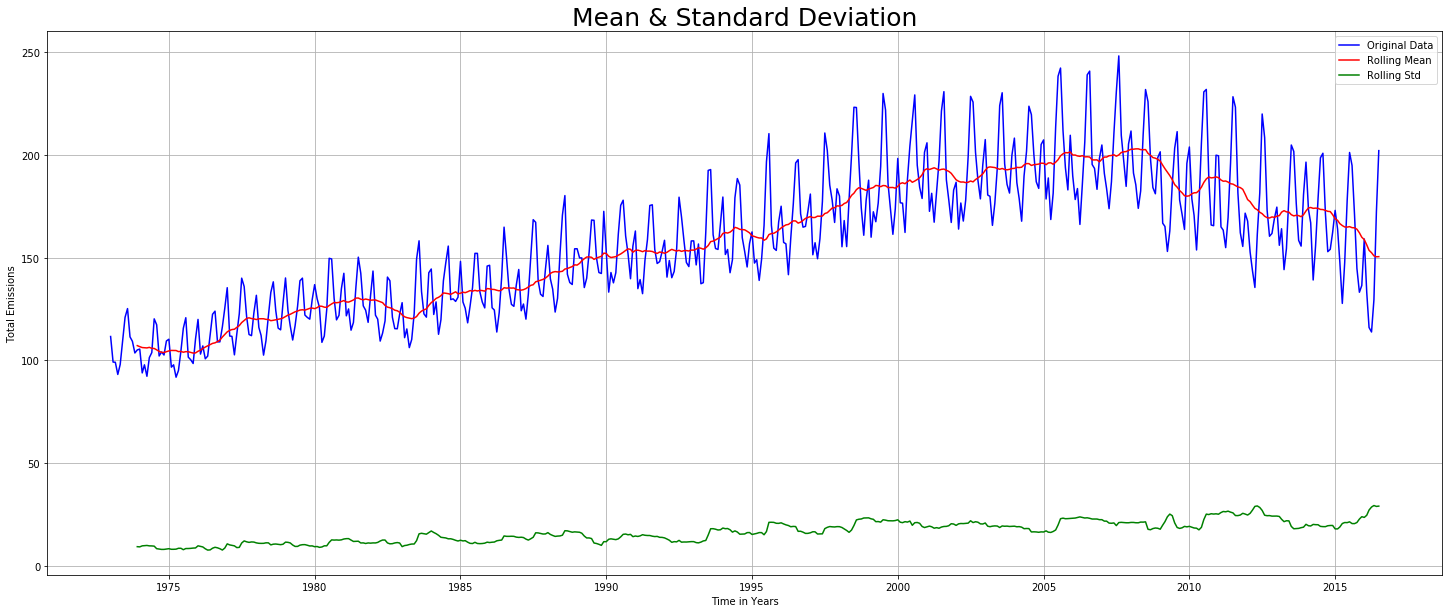

In [0]:
TestStationaryPlot(ts_value)

In [0]:
#定义ADF法检验函数
def TestStationaryAdfuller(ts_value, cutoff = 0.01):
    ts_test = adfuller(ts_value, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [0]:
TestStationaryAdfuller(ts_value)

Test Statistic                  -1.809627
p-value                          0.375693
#Lags Used                      14.000000
Number of Observations Used    508.000000
Critical Value (1%)             -3.443288
Critical Value (5%)             -2.867246
Critical Value (10%)            -2.569809
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


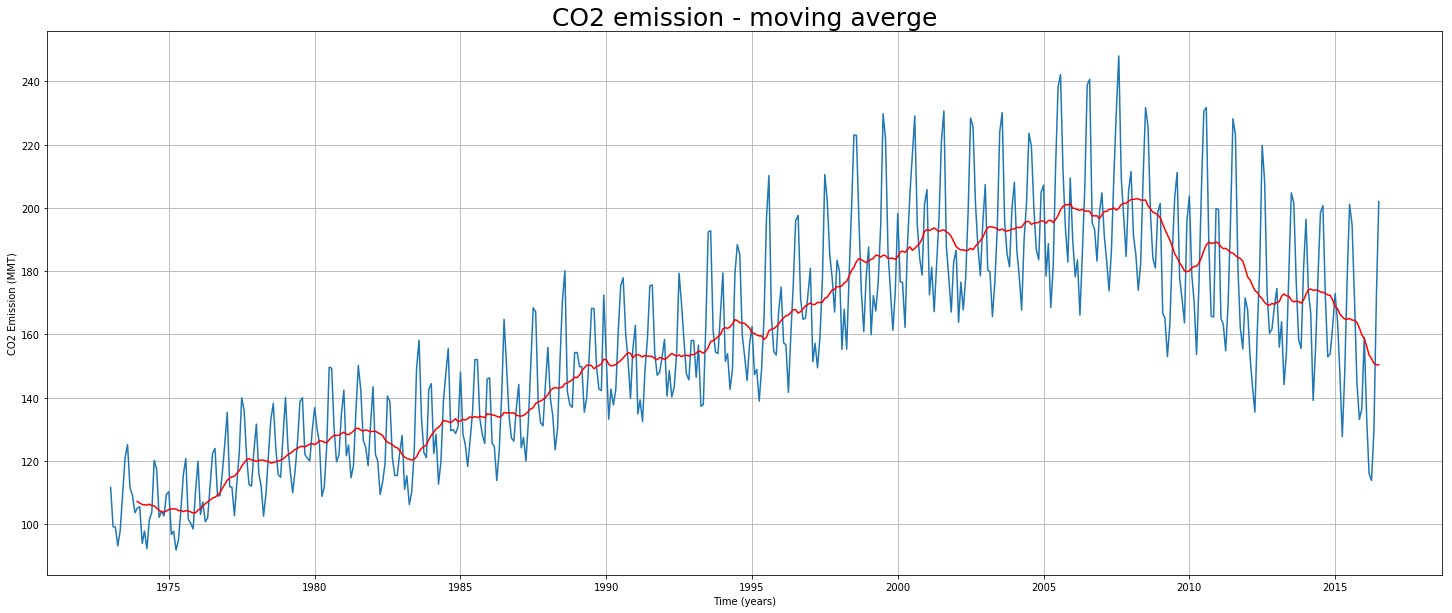

In [0]:
#去除趋势项：滑动平均法
#采用过去一年（12个月）的平均值(红线)
moving_avg = ts_value.rolling(12).mean()
plt.figure(figsize=(25,10))
plt.grid(True,'both')
plt.plot(ts_value)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('CO2 Emission (MMT)', fontsize = 10)
plt.title('CO2 emission - moving averge', fontsize = 25)
plt.show()

In [0]:
ts_value_moving_avg_diff = ts_value - moving_avg
ts_value_moving_avg_diff.head(13)

YYYYMM
1973-01-01         NaN
1973-02-01         NaN
1973-03-01         NaN
1973-04-01         NaN
1973-05-01         NaN
1973-06-01         NaN
1973-07-01         NaN
1973-08-01         NaN
1973-09-01         NaN
1973-10-01         NaN
1973-11-01         NaN
1973-12-01   -2.107083
1974-01-01   -1.158500
Name: Value, dtype: float64

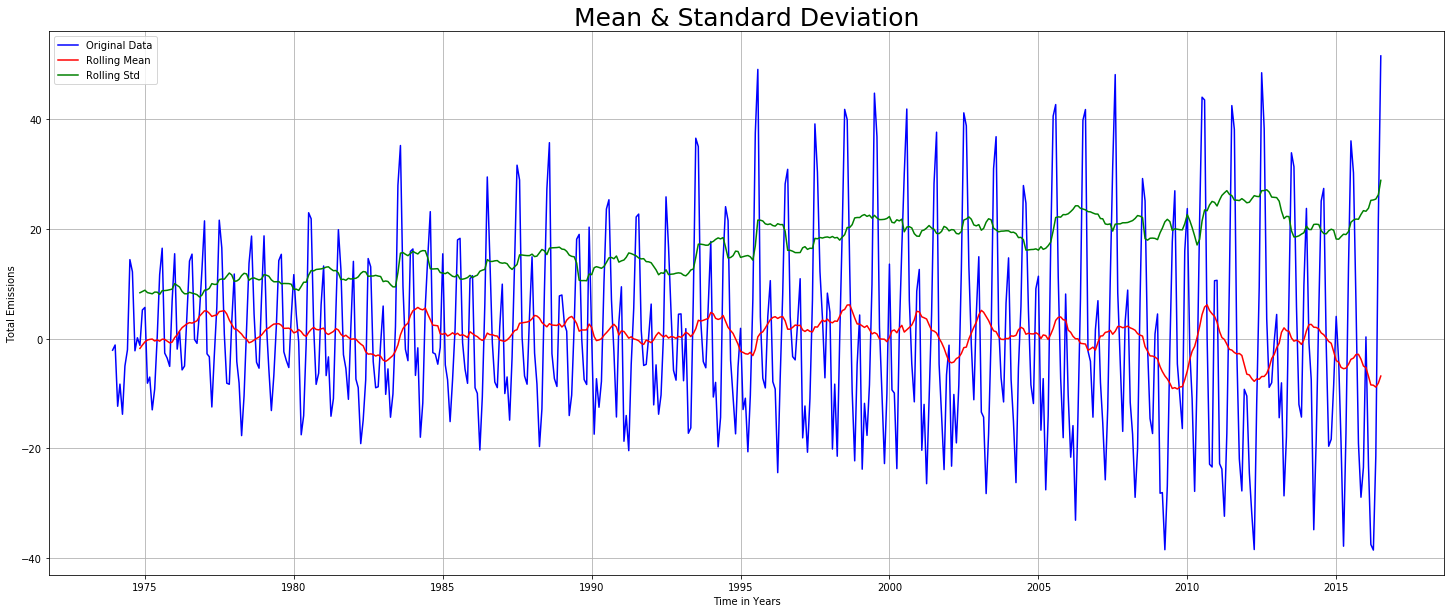

In [0]:
#检验平稳性
ts_value_moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(ts_value_moving_avg_diff)

In [0]:
TestStationaryAdfuller(ts_value_moving_avg_diff)

Test Statistic                -6.289158e+00
p-value                        3.635108e-08
#Lags Used                     1.400000e+01
Number of Observations Used    4.970000e+02
Critical Value (1%)           -3.443576e+00
Critical Value (5%)           -2.867373e+00
Critical Value (10%)          -2.569877e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


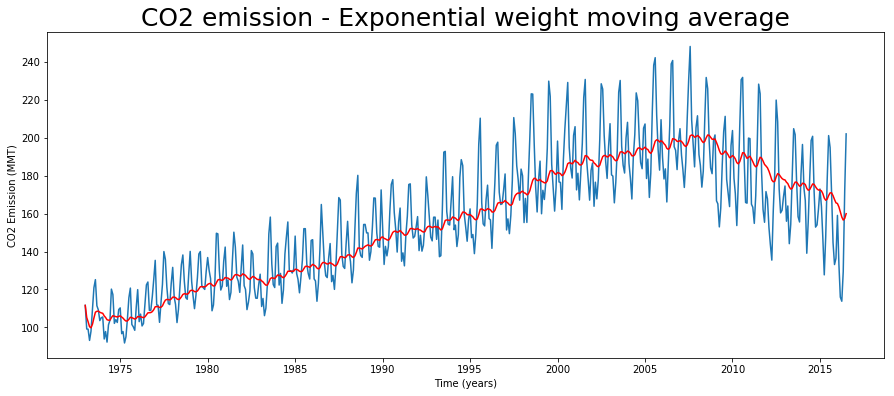

In [0]:
#利用指数平滑法进行趋势项剔除
ts_value_exp_wighted_avg = ts_value.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
plt.plot(ts_value)
plt.plot(ts_value_exp_wighted_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('CO2 Emission (MMT)', fontsize = 10)
plt.title('CO2 emission - Exponential weight moving average', fontsize = 25)
plt.show()

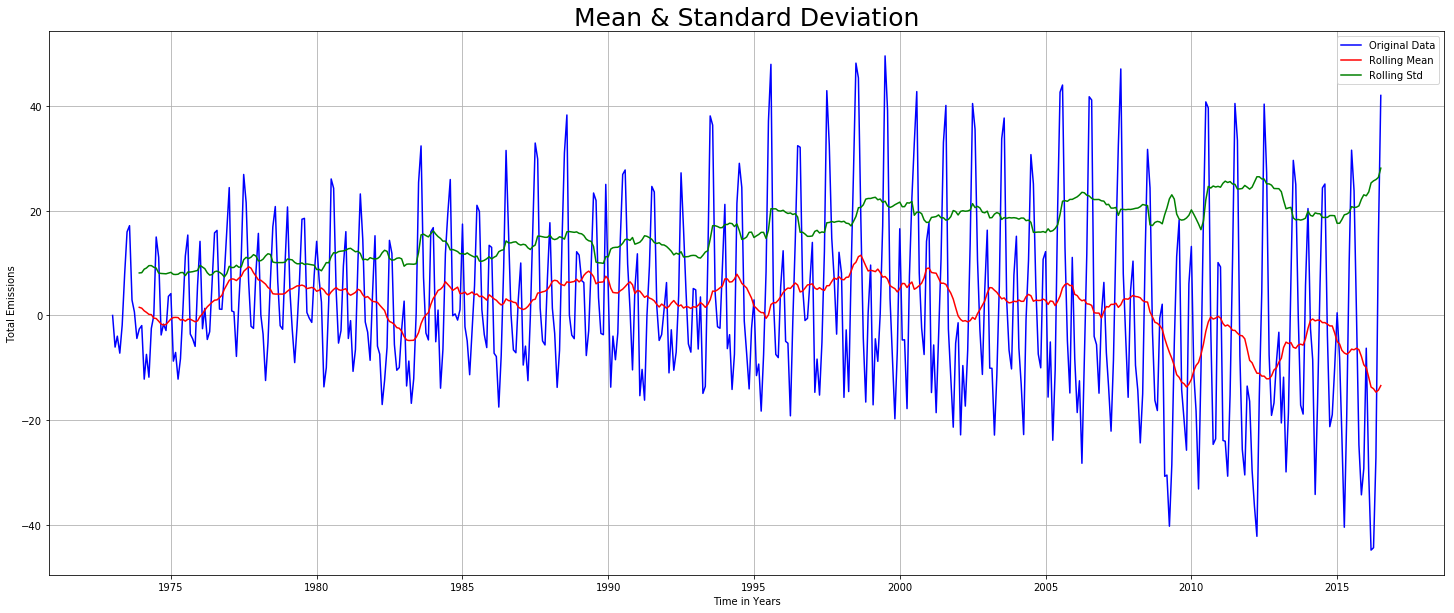

In [0]:
#减去指数加权平均值
ts_value_ewma_diff = ts_value - ts_value_exp_wighted_avg
TestStationaryPlot(ts_value_ewma_diff)

In [0]:
#测试稳定性--结果--平均值和标准差较小
TestStationaryAdfuller(ts_value_ewma_diff)

Test Statistic                  -3.152381
p-value                          0.022912
#Lags Used                      14.000000
Number of Observations Used    508.000000
Critical Value (1%)             -3.443288
Critical Value (5%)             -2.867246
Critical Value (10%)            -2.569809
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


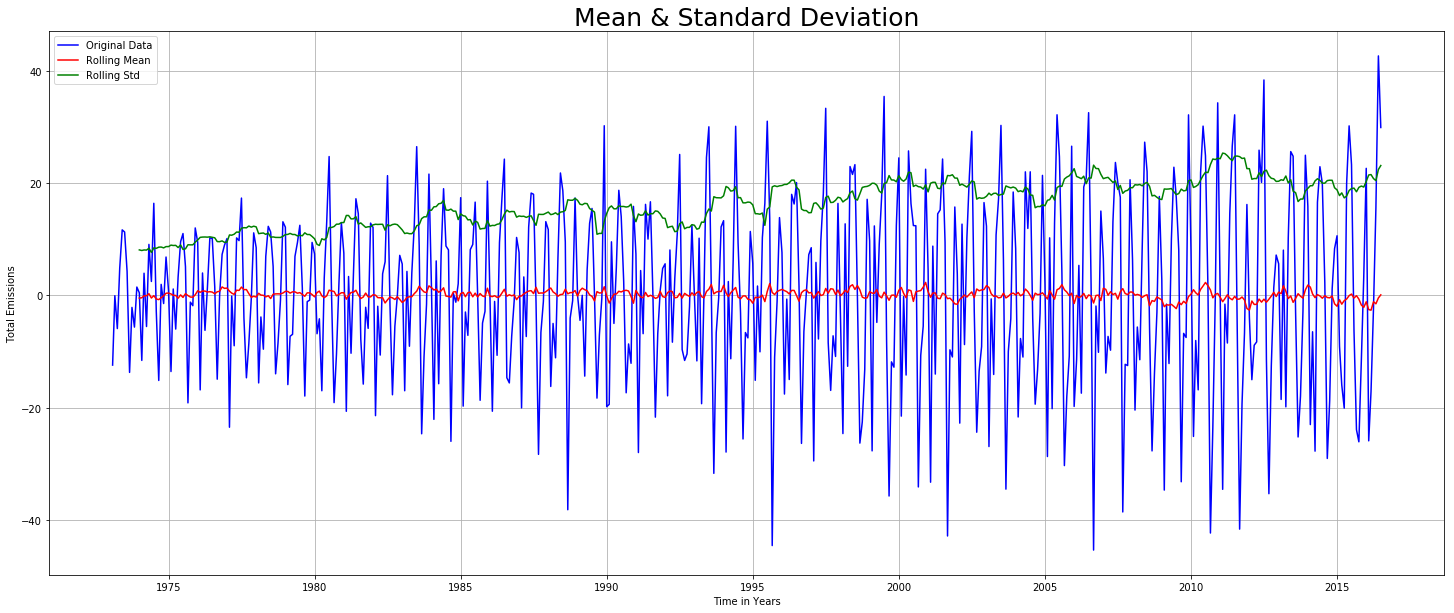

In [0]:
#趋势项一阶差分剔除（ARIMA)
ts_value_first_difference = ts_value - ts_value.shift(1)  
TestStationaryPlot(ts_value_first_difference.dropna(inplace=False))

In [0]:
TestStationaryAdfuller(ts_value_first_difference.dropna(inplace=False))

Test Statistic                -6.610275e+00
p-value                        6.402884e-09
#Lags Used                     1.300000e+01
Number of Observations Used    5.080000e+02
Critical Value (1%)           -3.443288e+00
Critical Value (5%)           -2.867246e+00
Critical Value (10%)          -2.569809e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


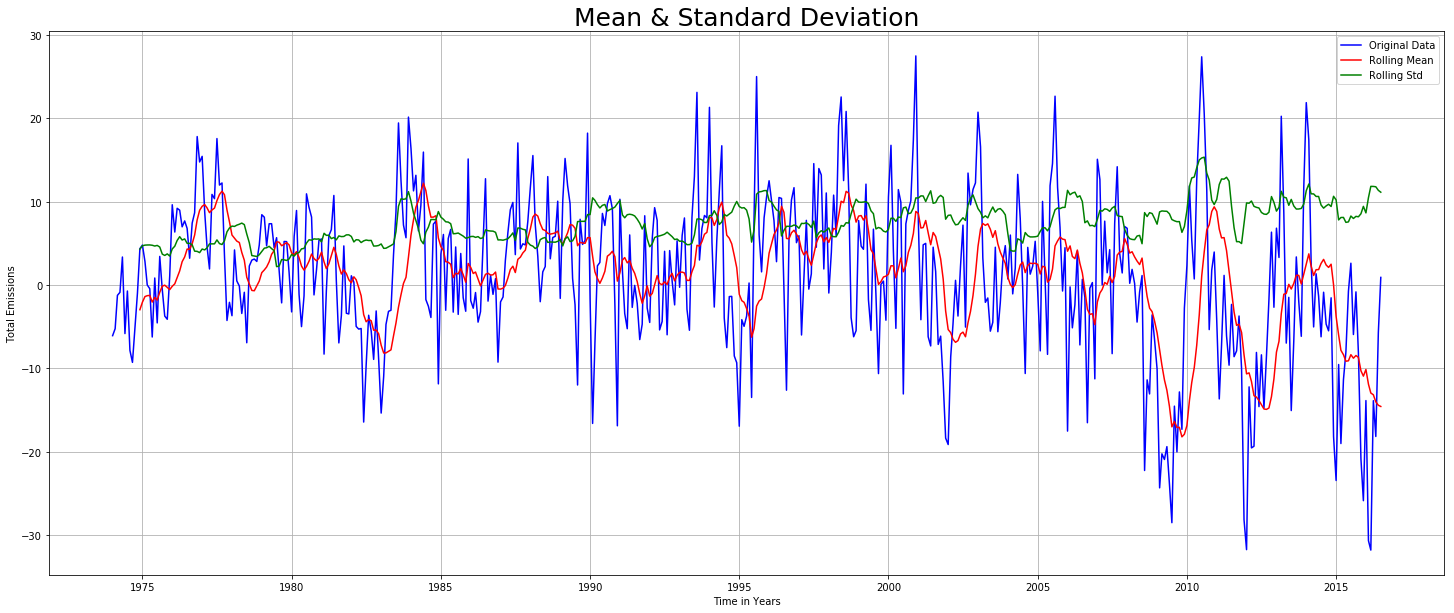

Test Statistic                  -5.495918
p-value                          0.000002
#Lags Used                      12.000000
Number of Observations Used    498.000000
Critical Value (1%)             -3.443549
Critical Value (5%)             -2.867361
Critical Value (10%)            -2.569870
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [0]:
#季节性差分
ts_value_seasonal_difference = ts_value - ts_value.shift(12)  
TestStationaryPlot(ts_value_seasonal_difference.dropna(inplace=False))
TestStationaryAdfuller(ts_value_seasonal_difference.dropna(inplace=False))

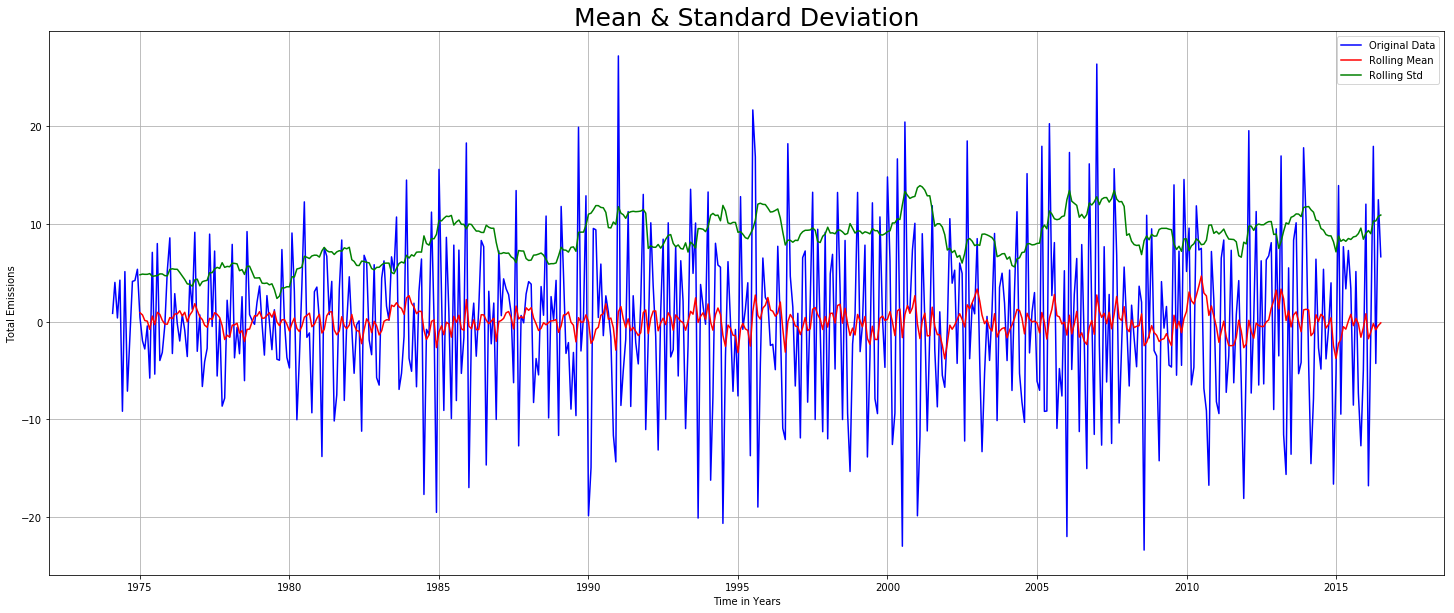

In [0]:
ts_value_seasonal_first_difference = ts_value_first_difference - ts_value_first_difference.shift(12)  
TestStationaryPlot(ts_value_seasonal_first_difference.dropna(inplace=False))

In [0]:
TestStationaryAdfuller(ts_value_seasonal_first_difference.dropna(inplace=False))

Test Statistic                -8.574894e+00
p-value                        8.012370e-14
#Lags Used                     1.400000e+01
Number of Observations Used    4.950000e+02
Critical Value (1%)           -3.443630e+00
Critical Value (5%)           -2.867397e+00
Critical Value (10%)          -2.569889e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


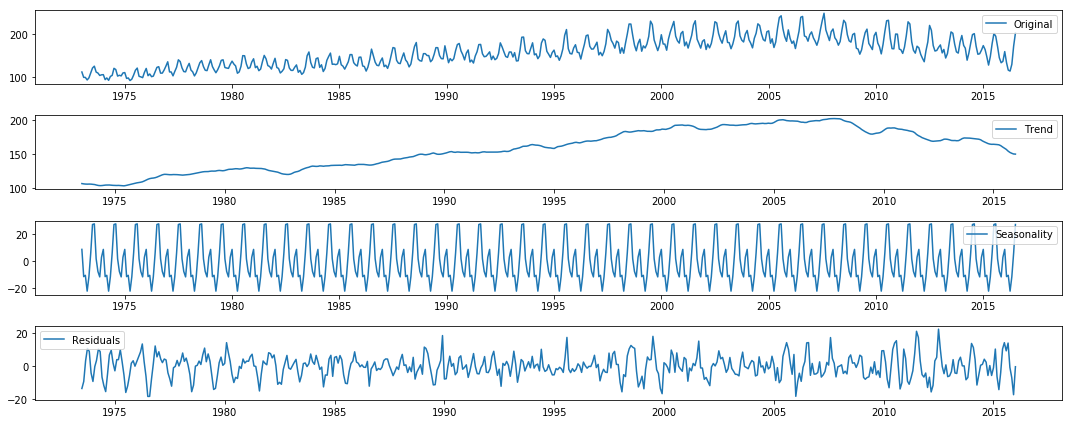

In [0]:
#对数据各项进行分解：趋势项，季节项，残差
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_value)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_value, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

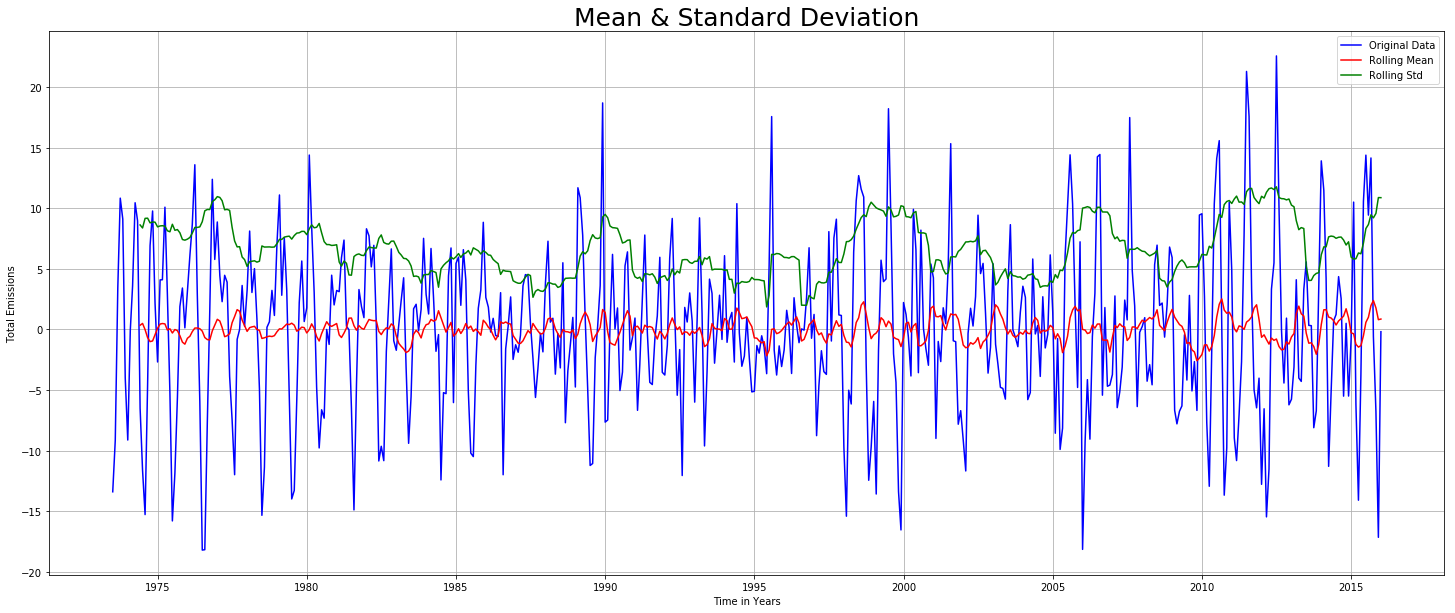

Test Statistic                -1.049037e+01
p-value                        1.151178e-18
#Lags Used                     1.400000e+01
Number of Observations Used    4.960000e+02
Critical Value (1%)           -3.443603e+00
Critical Value (5%)           -2.867385e+00
Critical Value (10%)          -2.569883e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [0]:
#对残差建模，平稳性检验
ts_value_decompose = residual
ts_value_decompose.dropna(inplace=True)
TestStationaryPlot(ts_value_decompose)
TestStationaryAdfuller(ts_value_decompose)

四、ARIMA建模

注：在寻找适合季节性ARIMA模型的时间序列数据时，第一个目标是找到优化度量的ARIMA（p，d，q）的值 \\
 有许多准则和最佳实践来实现这一目标，其他统计编程语言（如R）提供了解决此问题的自动方法，但尚未将其移植到Python。 \\
 我们将通过编写Python代码以编程方式为ARIMA（p，d，q）的时间序列模型选择最佳参数值来解决此问题。 \\
 ARIMA: 模型的三个参数：AR(p)，MA(q)，差分次数（d）。 \\
 参考：https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3#step-4-%E2%80%94-parameter-selection-for-the-arima-time-series-model


 稳定序列中有两种情况：
 1. 第一种情况是严格固定的序列，不具有相关性。我们可以将残差建模为白噪声。 \\
 2. 第二种情况是具有显著相关性的，需要采用类似ARIMA这样的统计模型来预测未来的结果。

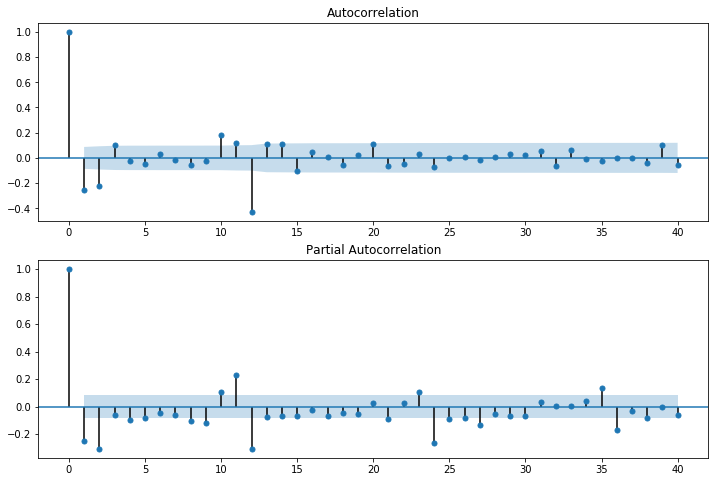

In [0]:
#自相关函数和偏自相关函数
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_value_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_value_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [0]:
#使用图形方法找到ARIMA模型的最佳参数很复杂。
#我们将使用grid search（hyperparameter optimization）方法系统地选择最佳参数值。
#迭代地搜索参数的不同组合。对于每个参数组合，我们将使用statsmodels模块中的SARIMAX（）函数拟合新的季节性ARIMA模型，并评估其整体质量。
#一旦我们探索了整个参数范围，我们的最佳参数集将是最佳性能的参数。首先生成各种参数组合：
#以下为测试代码：
p = d = q = range(0, 2) # 定义p，d，q为（0 - 2）之间的任意整数
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_x_QDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_x_QDQs[2]))

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)


In [0]:
for param in pdq:
    for seasonal_param in pdq_x_QDQs:
        try:
            mod = sm.tsa.statespace.SARIMAX(mte,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [0]:
#coef列显示每个特征的权重（即重要性）以及每个特征如何影响时间序列。 
#P>|z|列为每个特征权重的重要性。每个权重的p值接近0，因此在我们的模型中包含这些特征是合理的。

mod = sm.tsa.statespace.SARIMAX(ts_value, 
                                order=(1,1,1), 
                                seasonal_order=(0,1,1,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Value   No. Observations:                  523
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1609.807
Date:                            Fri, 19 Apr 2019   AIC                           3227.614
Time:                                    06:45:57   BIC                           3244.653
Sample:                                01-01-1973   HQIC                          3234.287
                                     - 07-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5155      0.049     10.599      0.000       0.420       0.611
ma.L1         -0.8992      0.026   

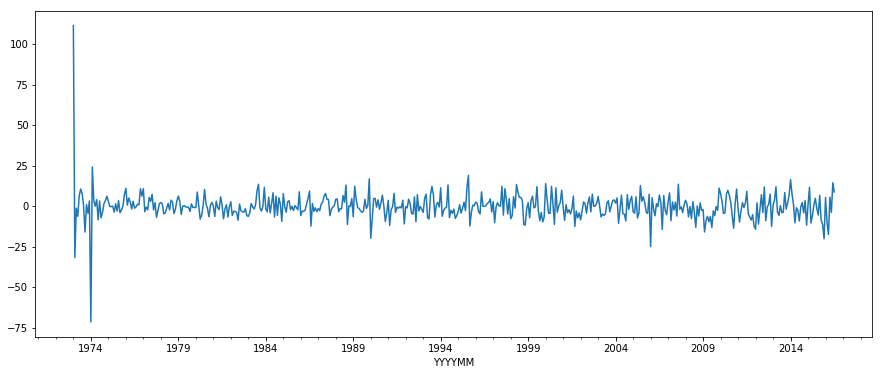

In [0]:
#绘制残差的图像
results.resid.plot()

In [0]:
#残差的统计特性
print(results.resid.describe())

count    523.000000
mean      -0.162548
std        8.636572
min      -71.385458
25%       -3.948264
50%       -0.313986
75%        3.471518
max      111.621000
dtype: float64


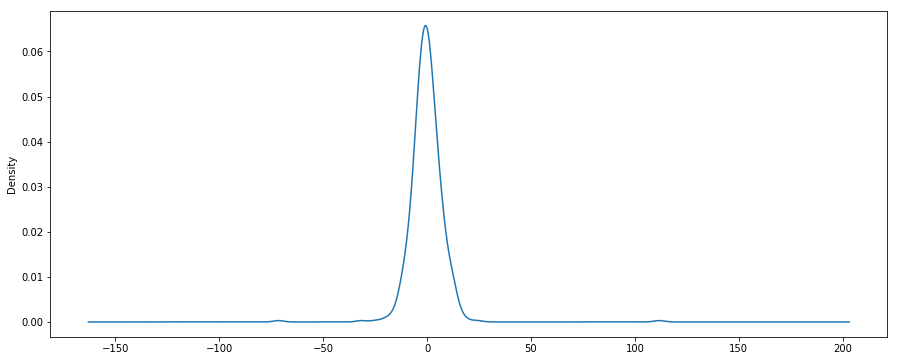

In [0]:
#上图显示了残差的分布。它显示了预测中的一点偏差。我们得到残差误差值概率密度图，误差是高斯误差，以零为中心
results.resid.plot(kind='kde')

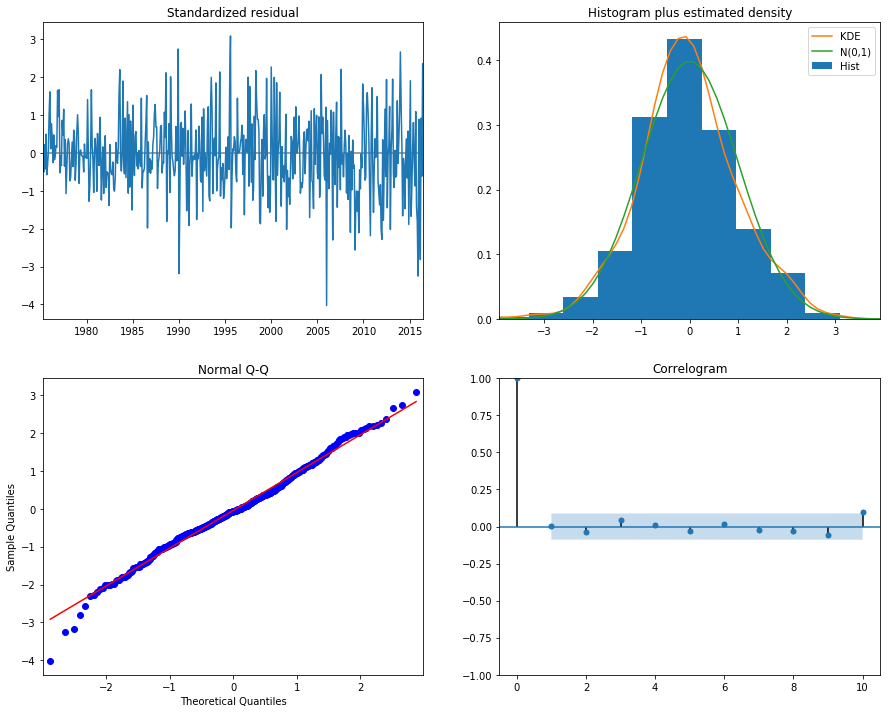

In [0]:
#根据残差的统计模型，对模型的非相关性，零均值进行检查。如果残差不满足这些特性，则需要改进模型。
results.plot_diagnostics(figsize=(15, 12))
plt.show()

由上图可以看出残差模型符合正态分布： \\
1、在图2中，橙色的KED线形态接近绿色的标准正态分布曲线。残差为正态分布，但存在一些偏离。 \\
2、在图3中，残差的分布（蓝点）遵循从标准正态分布中取得的样本的线性趋势。同样，这是残差正常分布的强烈迹象。 \\
3、随着时间的推移，残差（图1）无季节性，近似白噪声，通过右下角的自相关（图4）证实，这表明时间序列残差与其自身的时间平移存在低相关性。

五、模型检验

In [0]:
# 我们现在已经有了模型，可以通过模型的数据进行预测。通过截取部分数据进行预测，然后将预测值和数据值进行比较已验证模型的准确性。
# dynamic = False参数确保生成一步预测，也就是每个点的预测都是使用截至该点的完整历史生成的
pred = results.get_prediction(start = 480, end = 523, dynamic=False)
pred_ci = pred.conf_int()
pred_ci.head()

,lower Value,upper Value
2013-01-01,161.741247,185.947913
2013-02-01,140.065784,164.272449
2013-03-01,139.844217,164.050882
2013-04-01,135.304387,159.511052
2013-05-01,147.855272,172.061938


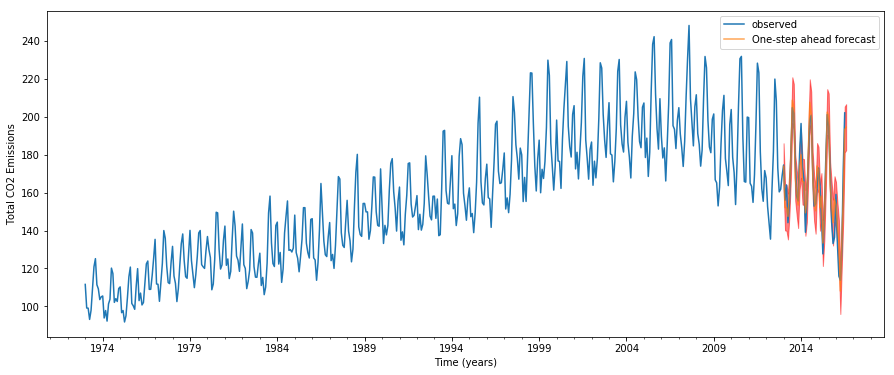

In [0]:
#将实际值和预测值画图，进行对比
ax = ts_value['1973':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Total CO2 Emissions')
plt.legend()

plt.show()

In [0]:
# 上图表明，预测值与实际值匹配较好。我们可以利用实际值和预测值的方差来评估预测水平
ts_value_forecast = pred.predicted_mean
ts_value_truth = ts_value['2013-01-31':]

# Compute the mean square error
ts_value_mse = ((ts_value_forecast - ts_value_truth) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(ts_value_mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
      .format(np.sqrt(sum((ts_value_forecast-ts_value_truth)**2)/len(ts_value_forecast))))

The Mean Squared Error (MSE) of the forecast is 66.53
The Root Mean Square Error (RMSE) of the forcast: nan


In [0]:
ts_value_pred_concat = pd.concat([ts_value_truth, ts_value_forecast])

In [0]:
#pred_dynamic = results.get_prediction(start=pd.to_datetime('2013-01-31'), dynamic=True, full_results=True)
#pred_dynamic_ci = pred_dynamic.conf_int()
#ax = ts_value['1973':].plot(label='observed', figsize=(20, 15))
#pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

#ax.fill_between(pred_dynamic_ci.index,
#                pred_dynamic_ci.iloc[:, 0],
#                pred_dynamic_ci.iloc[:, 1], 
#                color='r', 
#                alpha=.3)

#ax.fill_betweenx(ax.get_ylim(), 
#                 pd.to_datetime('2013-01-31'), 
#                 ts_value.index[-1],
#                 alpha=.1, zorder=-1)
#
#ax.set_xlabel('Time (years)')
#ax.set_ylabel('CO2 Emissions')
#
#plt.legend()
#plt.show()
# Extract the predicted and true values of our time series
#ts_value_forecast = pred_dynamic.predicted_mean
#ts_value_orginal = ts_value['2013-01-31':]
#
# Compute the mean square error
#ts_value_mse = ((ts_value_forecast - ts_value_orginal) ** 2).mean()
#print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(ts_value_mse, 2)))
#print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
#     .format(np.sqrt(sum((ts_value_forecast-ts_value_orginal)**2)/len(ts_value_forecast))))

六、预测

In [0]:
# Get forecast of 10 years or 120 months steps ahead in future
forecast = results.get_forecast(steps= 120)
# Get confidence intervals of forecasts
forecast_ci = forecast.conf_int()
forecast_ci.head()

,lower Value,upper Value
2016-08-01,182.314772,206.521437
2016-09-01,146.551059,174.985779
2016-10-01,126.140163,156.325596
2016-11-01,120.035356,151.178018
2016-12-01,133.983022,165.774341


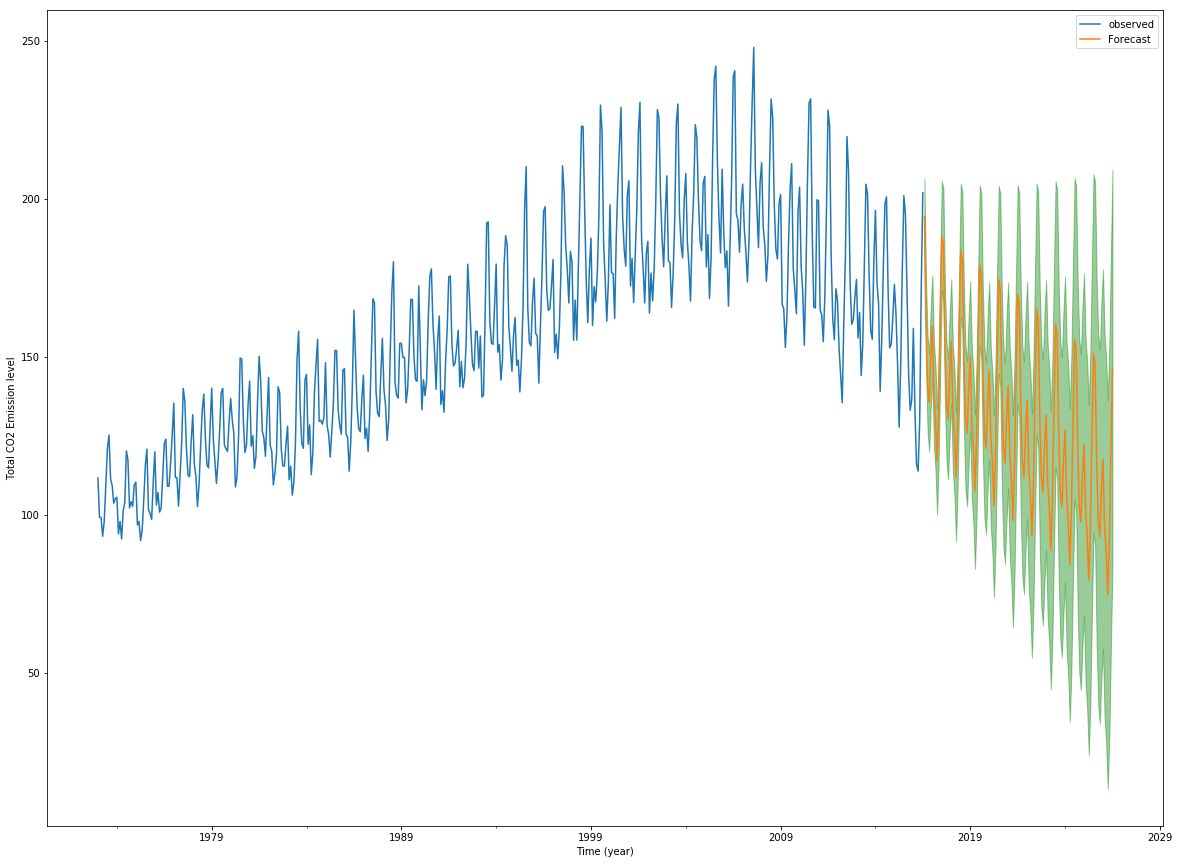

In [0]:
#预测未来20年每月的二氧化碳排放量
ax = ts_value.plot(label='observed', figsize=(20, 15))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='g', alpha=.4)
ax.set_xlabel('Time (year)')
ax.set_ylabel('Total CO2 Emission level')

plt.legend()
plt.show()

In [0]:
#Reference:
# A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python)(https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)
# A Guide to Time Series Forecasting with ARIMA in Python 3(https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3#step-4-%E2%80%94-parameter-selection-for-the-arima-time-series-model)
# IBM Watson Studio: Predicting Spot Exchange Rates with ARIMA (https://dataplatform.cloud.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c)